# Random Graphs

A [random graph](https://en.wikipedia.org/wiki/Random_graph) is obtained by starting with a set of n isolated vertices and adding successive edges between them at random. The Erdős–Rényi model denoted G(n,M), assigns equal probability to all graphs with exactly M edges. With 0 ≤ M ≤ N, G(n,M) has ${\tbinom {N}{M}}$ elements and every element occurs with probability $1/{\tbinom {N}{M}}$.

Let's start by importing a few libraries

In [1]:
import random
from collections import Counter,defaultdict
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Basic principles

The `random.sample()` function has the feature that it will draw sets of distinct numbers, for example, to draw two numbers in the range from 0 to 99, where the two numbers are always different we can do the following:

In [2]:
N=100
random.sample(range(N),2)

[83, 54]

We will label the vertices of the graph by integers, and this permits specifying random edges. Suppose we want a random graph with `N` vertices and an average of `z` neighbors per vertex, how many total edges should we add? Let `L` be the number of edges. Each edge contributes 1 to the degree of each of the vertices to which it's incident, so that means `2*L=N*z`. That means we need to add `L=N*z/2.` edges in order to have an average degree of `z`.  Let's create a graph with `N=100000` vertices and average degree `z=5`. Let `E` be the set of edges for the graph,

In [3]:
z=5
N=100000

In [4]:
E=set()
L=N*z/2.
while(len(E)<L): E.add(tuple(random.sample(range(N),2)))

The above code creates a set of exactly `L` random edges drawn from the total possible ${N\choose2}=N(N-1)/2$. In this case the probability of an edge is given by $p=L/{N\choose2}$. (Note that while `random.sample()` always draws distinct vertices to make an edge, it might draw the same edge more than once if `p` is large enough. But `E` is defined as a `set()`, so edges are only counted once and that won't affect anything. The `tuple()` in the above converts a two element list, e.g., [23,72], to a tuple (23,72), which for our purposes is an object that can serve as an element of a set.

### Let's start

We will use the graph created above and calculate the mean and standard deviation of the degree distribution of the vertices. To do this, it is useful to make a list of the vertices in the above edge set, counted with multiplicity:

In [5]:
degree=Counter([n for l in E for n in l])

The `degree` dictionary gives the number of times each vertex occurs in the original edge set E, i.e., its degree. 

We also need to take care of the vertices with degree zero

In [6]:
zeros=N-len(degree)
degree.update({k:0 for k in range(N) if k not in degree})
zeros

694

Calling `np.mean()` and `np.std()` on the `.values()` of the `degree` dictionary will then give the mean and standard deviation of the degree distribution.
We will also check that the mean is close to the desired `z`, and that the standard deviation is what one would expect for a Poisson distribution of degrees.

In [7]:
print(np.sum(list(degree.values())))
print(np.mean(list(degree.values())),'is close to',z)
print(np.std(list(degree.values())),'is close to',np.sqrt(z))

500000
5.0 is close to 5
2.23867818143 is close to 2.2360679775


### Plot histogram of the degree distribution

First let's define the function

In [8]:
from scipy.misc import factorial
def poisson(m,z=1): return np.exp(-z)*z**m/factorial(m)

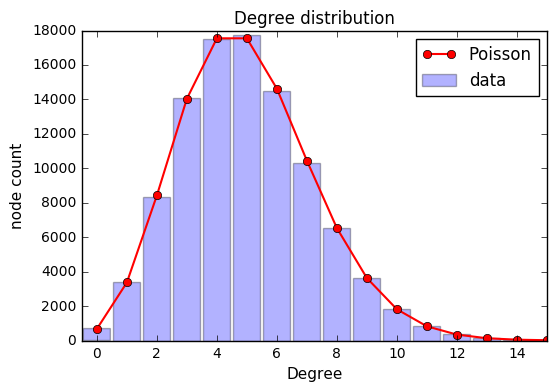

In [9]:
plt.hist(list(degree.values()),bins=range(20),align='left',alpha=0.3, rwidth = 0.9, label='data')
plt.plot(N*poisson(np.arange(20),np.mean(list(degree.values()))),'ro-',linewidth=1.5, label='Poisson')
# axes and labels
plt.title('Degree distribution',fontsize=12)
plt.xlabel('Degree',fontsize=11)
plt.xlim(-.5,15)
plt.ylabel('node count',fontsize=11)
plt.legend();

### Now, let's test the "your friends have more friends than you do" idea

We will use `randint(N,size=100)` to pick 100 vertices at random, and calculate the average degree of those vertices. That average should again be close to z.

In [10]:
np.mean([degree[j] for j in np.random.randint(N,size=100)])

4.96

Now instead we pick 100 vertices at random, and for each of those vertices we pick one of its neighbors at random, and calculate the average degree of those 100 neighbors. To do this efficiently, it will be useful to create a new dictionary `neighbors[]`, which has vertices as keys and for each vertex a list of its neighbors as value.

In [11]:
neighbors=defaultdict(list)
for j1,j2 in E:
    neighbors[j1].append(j2)
    neighbors[j2].append(j1)

Then `random.choice(neighbors[8])` will choose one of those five neighbors at random. Using these as keys to the `degree[]` counter permits finding the mean of the degrees of the 100 random friends of the 100 random vertices chosen. 
We will check wheter that mean is greater than the mean of part 1, and if so if it is greater by the expected amount (where for Poisson the variance is equal to the mean so mean + var/mean = mean + 1):

In [12]:
random_neighbors=[random.choice(neighbors[j]) for j in np.random.randint(N,size=100)]
expected=np.mean(list(degree.values())) + np.var(list(degree.values()))/np.mean(list(degree.values()))
print(np.mean(list([degree[j] for j in random_neighbors])),'is larger than',np.mean(list(degree.values())),\
      'and close to',expected)

5.82 is larger than 5.0 and close to 6.002336


### Finally, let's try to construct a more realistic social network

Social graphs are characterized by the "triadic closure" property. For each vertex, we can construct a list of distinct pairs of friends:

    friend_pairs= [(f1,f2) for f1 in neighbors[j] for f2 in neighbors[j] if f1<f2]
    
Some of these `(f1,f2)` edges will already be in `F`, but only with small probability `p`. 
The *clustering coefficient* for vertex `j` is given by the ratio of closed triangles over total number of possible closed triangles. For the above list of friend pairs, that's just the number of current edges `(f1,f2)` in `F` divided by the length of the list. 

We are going to determine the average clustering coefficient of the graph by summing the clustering coefficients for all the vertices and dividing by the number of vertices.

In [13]:
clust_coeff=0
for j in sorted(neighbors):
    friend_pairs= [(i1,i2) for i1 in neighbors[j] for i2 in neighbors[j] if i1<i2]
    if len(friend_pairs) == 0: continue
    clust_coeff += sum([i1 in neighbors[i2] for i1,i2 in friend_pairs])/float(len(friend_pairs))
print('average clustering coefficient',clust_coeff/float(len(neighbors)))

average clustering coefficient 3.994264764006774e-05


In [14]:
F=E.copy()

for j in sorted(neighbors):
    friend_pairs= [(i1,i2) for i1 in neighbors[j] for i2 in neighbors[j] if i1<i2]
    for edge in friend_pairs:
        if np.random.rand()>.5: F.add(edge)

Now, the number of edges in the edge set F should be more than three times as many.

In [15]:
len(E),len(F)

(250000, 876178)

We can calculate the mean and standard deviation of the degree distribution of F.

In [16]:
fdegree=Counter([n for l in F for n in l])
avg=np.mean(list(fdegree.values())+zeros*[0])
stdev=np.std(list(fdegree.values())+zeros*[0])
print('mean =',avg)
print('standard deviation =',stdev)

mean = 17.52356
standard deviation = 8.59866181021


In [17]:
fneighbors=defaultdict(list)
for j1,j2 in F:
    fneighbors[j1].append(j2)
    fneighbors[j2].append(j1)

The average clustering coefficient is now:

In [18]:
clust_coeff=0
for j in sorted(fneighbors):
    friend_pairs= [(i1,i2) for i1 in fneighbors[j] for i2 in fneighbors[j] if i1<i2]
    if len(friend_pairs) == 0: continue
    clust_coeff += sum([i1 in fneighbors[i2] for i1,i2 in friend_pairs])/float(len(friend_pairs))
print('average clustering coefficient',clust_coeff/float(len(neighbors)))

average clustering coefficient 0.21727725319741498


The clustering coefficient is much larger than the one found above. 